In [1]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

# MPC with Obstacle Avoidance as Soft Constraint

### Advantage of Soft Constraint

- **Solver Robustness**: Hard constraints can lead to "Restoration Phase" errors in IPOPT if the robot starts inside an obstacle or is pushed into one. Soft constraints ensure the solver always finds a "best-effort" solution.

- **Computational Speed**: Reducing the number of hard constraints in the $g$ vector often leads to faster iterations

The two primary methods to achieve this are the **Penalty Method** and the **Slack Variable** Approach.

## Method-1: The Penalty Method

In this method, we convert obstacle avoidance into a soft constraint by moving the collision logic into the objective function ($J$) as a penalty term, instead of setting a strict boundary that the solver must never cross. In short, the Penalty Method converts an inequality constraint into a part of the objective function.

If our hard constraint is defined as $g(x) \ge 0$, where $g(x)$ is the squared distance minus the safety radius, we define a violation as:

$$v(x) = \max(0, -g(x))$$

We then augment the original cost function $J_{target}$ with a penalty term:

$$
J_{total} = J_{target} + J_{obstacle} = J_{target} + \lambda \sum_{k=1}^{N} v(x_k)^2
$$

where the obstacle penalty at each time step $k$ is:

$$
J_{obs, k} = \lambda \cdot \max(0, r_{safe}^2 - d_k^2)^2
$$

- $d_k^2$: The squared distance $(x_k - x_{obs})^2 + (y_k - y_{obs})^2$
- $\lambda$: The penalty weight. A higher $\lambda$ makes the obstacle "harder" to cross. If it is too large, the problem may become numerically unstable.
- **Quadratic Term**: Squaring the violation ensures the cost function remains differentiable and penalizes deeper penetrations much more severely than slight ones.
- **Advantage**: it does not require adding new decision variables to the solver and always mathematically feasible

#### Parameters

In [2]:
N = 10
dt = 0.1
target = [10.0, 10.0, 0.0]
start = [0.0, 0.0, 0.0]

# Obstacle footprint (meters)
obs_x, obs_y = 5.0, 5.0
obs_radius = 1.0
ego_radius = 0.5
min_dist_sq = (obs_radius + ego_radius) ** 2

# Penalty Weight - Controls how "strict" the soft constraint is
lambda_obs = 1000.0 # Tune it to see how the behavior changes

#### Unicycle

In [3]:
x_sym = ca.SX.sym("x", 3)
u_sym = ca.SX.sym("u", 2)
rhs = ca.vertcat(u_sym[0] * ca.cos(x_sym[2]), u_sym[0] * ca.sin(x_sym[2]), u_sym[1])
x_next = x_sym + rhs * dt
unicycle = ca.Function("f", [x_sym, u_sym], [x_next])

#### Optimization Setup

**Cost Landscape:** 

By using `ca.fmax(0, violation)**2`, we create a "smooth" slope. When the robot is far away, the penalty is zero. As it enters the safety margin, the cost rises quadratically.

In [4]:
U = []
J = 0

P = ca.SX.sym("P", 3)
curr_state = P

for k in range(N):
    u_k = ca.SX.sym(f"U_{k}", 2)
    U.append(u_k)

    # Evolve State
    curr_state = unicycle(curr_state, u_k)

    # Target Cost (Stage)
    dist_sq = (curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2
    J += dist_sq

    # Obstacle Penalty (Soft Constraint)
    dist_to_obs_sq = (curr_state[0] - obs_x) ** 2 + (curr_state[1] - obs_y) ** 2

    # violation is positive if distance < safety radius
    violation = ca.fmax(0, min_dist_sq - dist_to_obs_sq)
    J += lambda_obs * (violation**2)

# Terminal Cost
J += 10 * ((curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2)

#### Solver Setup

In [5]:
OPT_variables = ca.vertcat(*U)

# Notice there's no `g` as there are no hard constraints
nlp_prob = {"f": J, "x": OPT_variables, "p": P}

opts = {
    "ipopt.print_level": 0,
    "print_time": False,
    "ipopt.tol": 1e-4,
    "ipopt.warm_start_init_point": "yes",
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, opts)

#### Bounds

In [6]:
lbx = [-5, -2] * N
ubx = [5, 2] * N

### MPC Routine

In [7]:
u_guess = [0] * (N * 2)

curr_state_num = np.array(start, dtype=np.float64)
path_x, path_y = [start[0]], [start[1]]

max_sim_steps = 200

for t in range(max_sim_steps):
    sol = solver(x0=u_guess, lbx=lbx, ubx=ubx, p=curr_state_num)
    u_opt = sol["x"].full().flatten()

    v_cmd, w_cmd = u_opt[0], u_opt[1]
    u_guess = np.concatenate((u_opt[2:], [0, 0]))

    theta = curr_state_num[2]
    curr_state_num[0] += v_cmd * np.cos(theta) * dt
    curr_state_num[1] += v_cmd * np.sin(theta) * dt
    curr_state_num[2] += w_cmd * dt

    path_x.append(curr_state_num[0])
    path_y.append(curr_state_num[1])

    if (
        np.sqrt(
            (curr_state_num[0] - target[0]) ** 2 + (curr_state_num[1] - target[1]) ** 2
        )
        < 0.2
    ):
        break


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



#### Plot

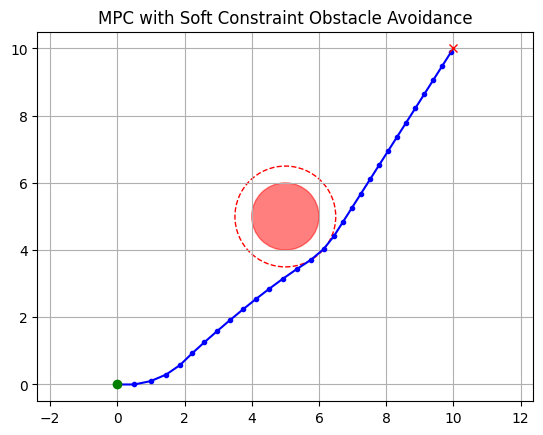

In [8]:
plt.figure()
plt.gca().add_patch(plt.Circle((obs_x, obs_y), obs_radius, color="r", alpha=0.5))
plt.gca().add_patch(
    plt.Circle(
        (obs_x, obs_y), obs_radius + ego_radius, color="r", fill=False, linestyle="--"
    )
)
plt.plot(path_x, path_y, "b-o", markersize=3, label="Robot Path")
plt.plot(start[0], start[1], "go", label="Start")
plt.plot(target[0], target[1], "rx", label="Target")
plt.axis("equal")
plt.grid(True)
plt.title("MPC with Soft Constraint Obstacle Avoidance")
plt.show()

## Method-2: The Slack Variable Approach

While the penalty method (adding a term directly to the cost function) is simpler to implement, it can introduce *numerical stiffness* when the penalty weight is too large. In such cases, the objective exhibits extremely steep gradients in some directions and nearly flat gradients in others, making optimization challenging.

Slack variables turn the inequality constraint into an equality-like structure that the optimizer can handle more gracefully, allowing for a "controlled" violation of constraints only when absolutely necessary for feasibility. It is done by introducing a new set of decision variables into the optimization problem specifically to "absorb" constraint violations.

**Math**

In a hard constraint, the robot is strictly forbidden from entering the safety radius: $g(x) \ge 0$. With a slack variable $\epsilon$, we relax the constraint to:

$$g(x) \ge 0 - \epsilon, \quad \epsilon \ge 0$$

- If $\epsilon = 0$: The hard constraint is perfectly satisfied
- If $\epsilon > 0$: The constraint is violated by a magnitude of $\epsilon$.

To ensure the robot doesn't use the slack unless it has to, we add a heavy penalty for $\epsilon$ to the objective function, often using a combination of L1 (linear) and L2 (quadratic) costs:

$$J_{total} = J_{target} + \lambda_1 \epsilon + \lambda_2 \epsilon^2$$

- **Linear Penalty** ($\lambda_1 \epsilon$): Acts like a constant force pushing the slack toward zero
- **Quadratic Penalty** ($\lambda_2 \epsilon^2$): Prevents large violations by increasing the cost exponentially as the violation grows.

This formulation is superior because it allows the solver to maintain a feasible search space even if the robot starts in a position where a collision is mathematically unavoidable (e.g., due to sensor noise or initialization).

#### Slack Penalties

In [9]:
lambda_1 = 1000.0  # Linear penalty (L1)
lambda_2 = 500.0  # Quadratic penalty (L2)

#### Optimization Setup

In [10]:
U = []  # Control variables
slack = []  # Slack variables
J = 0  # Cost
g = []  # Constraints

w_goal = 10.0

P = ca.SX.sym("P", 3)  # Parameter (current state)
curr_state = P

for k in range(N):
    u_k = ca.SX.sym(f"U_{k}", 2)
    s_k = ca.SX.sym(f"S_{k}", 1)  # One slack per time step

    U.append(u_k)
    slack.append(s_k)

    # Evolve State
    curr_state = unicycle(curr_state, u_k)

    # A. Target Cost
    dist_to_goal = (curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2
    J += dist_to_goal

    # B. Slack Penalty (Softening the constraint)
    J += lambda_1 * s_k + lambda_2 * s_k**2

    # C. Constraint with Slack: dist^2 + slack >= min_dist^2
    dist_to_obs_sq = (curr_state[0] - obs_x) ** 2 + (curr_state[1] - obs_y) ** 2
    g.append(dist_to_obs_sq + s_k)

# Terminal Cost
J += w_goal * ((curr_state[0] - target[0]) ** 2 + (curr_state[1] - target[1]) ** 2)

#### Solver Setup

We interleave $U$ and $S$ so the decision vector is $[v_0, w_0, s_0, v_1, w_1, s_1, \cdots]$

In [11]:
OPT_vars = []
for i in range(N):
    OPT_vars.append(U[i])
    OPT_vars.append(slack[i])

OPT_variables = ca.vertcat(*OPT_vars)
OPT_constraints = ca.vertcat(*g)

nlp_prob = {"f": J, "x": OPT_variables, "p": P, "g": OPT_constraints}

opts = {
    "ipopt.print_level": 0,
    "print_time": False,
    "ipopt.tol": 1e-4,
    "ipopt.warm_start_init_point": "yes",
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, opts)

#### Bounds

In [12]:
lbx, ubx = [], []

for _ in range(N):
    lbx += [-5, -2, 0]  # Linear vel, Angular vel, Slack (S >= 0)
    ubx += [5, 2, ca.inf]  # S can go up to infinity if needed

# Constraint bounds: g >= min_dist_sq
lbg = [min_dist_sq] * N
ubg = [ca.inf] * N

#### MPC Loop

In [13]:
curr_state_num = np.array(start, dtype=np.float64)
path_x, path_y = [start[0]], [start[1]]
u_guess = [0] * (N * 3)  # Initial guess for [v, w, s] sequence

for t in range(max_sim_steps):
    sol = solver(x0=u_guess, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=curr_state_num)
    x_opt = sol["x"].full().flatten()

    # Extract first set of controls
    v_cmd = x_opt[0]
    w_cmd = x_opt[1]

    # Warm start: shift the solution
    u_guess = np.concatenate((x_opt[3:], [0, 0, 0]))

    # Evolve
    theta = curr_state_num[2]
    curr_state_num[0] += v_cmd * np.cos(theta) * dt
    curr_state_num[1] += v_cmd * np.sin(theta) * dt
    curr_state_num[2] += w_cmd * dt

    path_x.append(curr_state_num[0])
    path_y.append(curr_state_num[1])

    if (
        np.sqrt(
            (curr_state_num[0] - target[0]) ** 2 + (curr_state_num[1] - target[1]) ** 2
        )
        < 0.2
    ):
        break

#### Plot

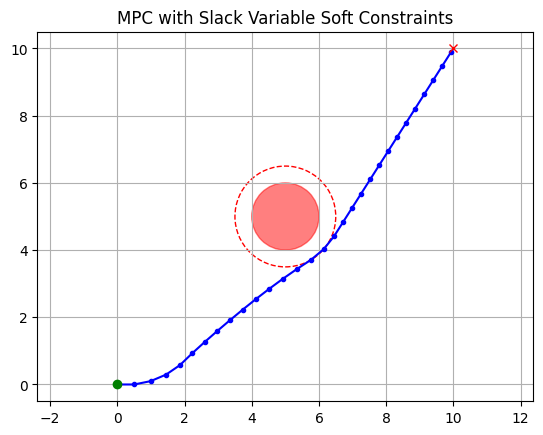

In [14]:
plt.figure()
plt.gca().add_patch(plt.Circle((obs_x, obs_y), obs_radius, color="r", alpha=0.5))
plt.gca().add_patch(
    plt.Circle(
        (obs_x, obs_y), obs_radius + ego_radius, color="r", fill=False, linestyle="--"
    )
)
plt.plot(path_x, path_y, "b-o", markersize=3, label="Robot Path")
plt.plot(start[0], start[1], "go", label="Start")
plt.plot(target[0], target[1], "rx", label="Target")
plt.axis("equal")
plt.grid(True)
plt.title("MPC with Slack Variable Soft Constraints")
plt.show()